In [ ]:
import tensorflow as tf, keras
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)


TensorFlow: 2.19.0
Keras: 3.10.0


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e5becceb-5321-190a-d8ab-2ee1d2c6329b)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:

# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# check all filenames in the target directory
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns teh lines of text as a list

  Args:
    filename: a string containing the target filepath to read.

  Returns:
    A list of strings with one string per line from the target filename.
    for example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's write a function to perform the following steps:

Take a target file of abstract samples.
Read the lines in the target file.
For each line in the target file:
If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
Keep count of the number of lines in a sample.
If the line begins with \n mark it as the end of an abstract sample.
Keep count of the total lines in a sample.
Record the text before the \t as the label of the line.
Record the text after the \t as the text of the line.
Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
"line_number" - the position of the line in the abstract (e.g. 3).
"target" - the role of the line in the abstract (e.g. OBJECTIVE).
"text" - the text of the line in the abstract.
"total_lines" - the total lines in an abstract sample (e.g. 14).
Abstract ID's and newlines should be omitted from the returned preprocessed data.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label , the text of the sentence,
  how many sentences are in tthe current abstract and what sentence number
  the target line is.

  Args:
    filename: a string of the target text file to read and extract line data from.

  Returns:
    A list of dictionaries each containing a line from an abstract,
    the lines label, the lines position  in the abstract and the total number of line
     in the abstract where ethe line is from. For example:
      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" #creates an empty abstract
  abstract_samples = [] #creates an empty list of abstracts

  # loop through each line in target file
  for line  in input_lines:
    if line.startswith('###'): #check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" #reset abstract string
    elif line.isspace(): #check to see if the line is a new line(\n)
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines


      #iterate thorugh each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create empty dict to store data from line
        target_text_split = abstract_line.split('\t') #split target label from text
        line_data['target'] = target_text_split[0] #get target label
        line_data['text'] = target_text_split[1].lower() #get target text and lower it
        line_data['line_number'] = abstract_line_number #what number line does the line appear on
        line_data['total_lines'] = len(abstract_line_split) -1 #how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) #add line data ot abstract samples list
    else: #if the above conditions aren't fulfilled , the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir+ 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir +'dev.txt') #dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples),len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

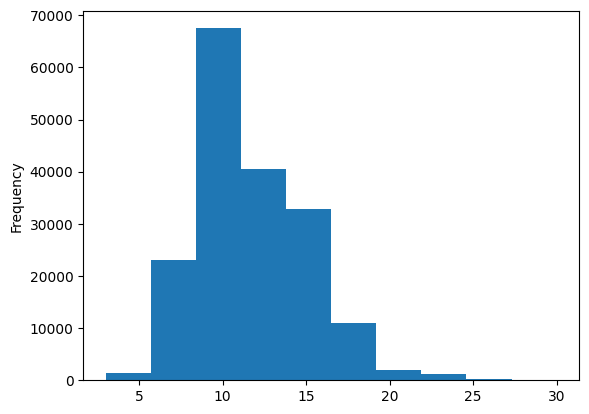

In [ ]:
train_df.total_lines.plot.hist()

# Get list of sentences
When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the tolist() method on our "text" columns.

In [ ]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences) , len(val_sentences) ,len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels( ML model requiers numeric labels)
We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# label encodded labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder =LabelEncoder()
train_labels_encoded= label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded  = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Creating a series of Model Experiments

## Model 0: Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

model_0.fit(X = train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_sentences,
              y= val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2025-09-18 17:37:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-09-18 17:37:30 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers



Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

In [ ]:
# how long is each sentence on average
sent_lens = [len(sentences.split()) for sentences in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

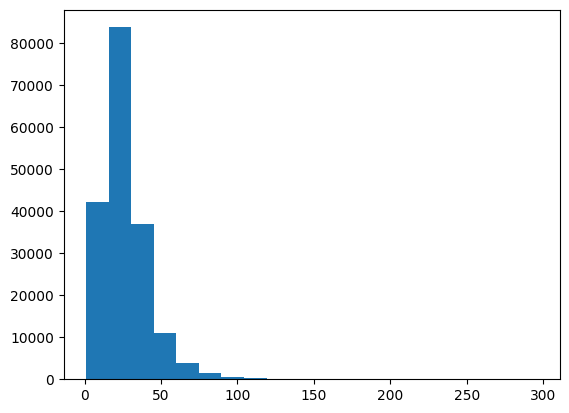

In [ ]:
# distribution?
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins = 20)

In [ ]:
# how long of a sentence covers 95% of the length?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

## Create Text Vectorizer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, #number of words in vocabulary
                                    output_sequence_length = 55) #desired output length of vectorized sequences

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorizer
import random
target_sentences = random.choice(train_sentences)
print(f'Text:\n{target_sentences}')
print(f'\nLength of text:{len(target_sentences.split())}')
print(f'\nVectorized text:\n{text_vectorizer([target_sentences])}')

Text:
no significant difference was found between the scores obtained with triphala and chlorhexidine mouthwashes .

Length of text:15

Vectorized text:
[[   33    37    74    10   208    30     2   119   527     7 21501     3
   3637 22510     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# how many words in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab :{len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab:{rct_20k_text_vocab[:5]}')
print(f'Least commong words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab :64841
Most common words in the vocab:['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least commong words in the vocab: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [ ]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create Custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128, #Note: different  embedding sizes result in drastically different number of parameters
                               mask_zero = True, #Use masking to handle variable sequence lengths(save space)
                               name = 'token_embedding')

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentences}\n")
vectorized_sentence = text_vectorizer([target_sentences])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
no significant difference was found between the scores obtained with triphala and chlorhexidine mouthwashes .

Sentence after vectorization (before embedding):
[[   33    37    74    10   208    30     2   119   527     7 21501     3
   3637 22510     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04512898  0.02122051  0.02982524 ...  0.00745799 -0.01912103
   -0.04813132]
  [-0.04635208  0.00707885 -0.01074172 ...  0.03509014 -0.01006653
   -0.01530312]
  [-0.04371172 -0.0031721  -0.00237584 ... -0.02696414 -0.03658197
    0.04866764]
  ...
  [-0.001537   -0.04064486 -0.01896138 ...  0.03630518  0.01240957
   -0.03702791]
  [-0.001537   -0.04064486 -0.01896138 ...  0.03630518  0.01240957
   -0.03702791]
  [-0.001537   -0.0

##Create datasets (as fast as possible)

The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# Turn our data inot Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the tensorsliceDatasets and turn them into prefetch batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
inputs  = layers.Input(shape = (1,), dtype = 'string')
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5172 - loss: 1.1646 - val_accuracy: 0.7384 - val_loss: 0.6930
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7440 - loss: 0.6852 - val_accuracy: 0.7686 - val_loss: 0.6421
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7721 - loss: 0.6238 - val_accuracy: 0.7822 - val_loss: 0.6005


In [ ]:
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7843 - loss: 0.5974


[0.599470853805542, 0.7846220135688782]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[4.2113861e-01, 1.4496066e-01, 7.9024479e-02, 3.2608747e-01,
        2.8788783e-02],
       [4.2897931e-01, 3.0578825e-01, 1.0064794e-02, 2.4497861e-01,
        1.0189151e-02],
       [1.2911566e-01, 4.5387950e-03, 2.4147097e-03, 8.6388683e-01,
        4.4018449e-05],
       ...,
       [3.7445693e-06, 6.9341168e-04, 6.5941509e-04, 3.4830400e-06,
        9.9864000e-01],
       [3.5456672e-02, 4.4673088e-01, 8.4243327e-02, 4.2676099e-02,
        3.9089304e-01],
       [1.9818178e-01, 6.5792441e-01, 5.2686382e-02, 3.3672396e-02,
        5.7535063e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.46220045015225,
 'precision': 0.7810528599146138,
 'recall': 0.7846220045015225,
 'f1': 0.7820666315304023}

##Model 2: Feature extraction with pretrained token embeddings

In [ ]:
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

In [ ]:
# test out the embedding on a random sentence
import random
random_training_sentence = random.choice(train_sentences)
print(f'Random training sentence:\n{random_training_sentence}\n')
use_embedded_sentence = embed([random_training_sentence])
print(f'Sentence after embedding"\n{use_embedded_sentence[0][:30]}(truncated outputs)\n')
print(f'length of sentence embedding:\n{len(use_embedded_sentence[0])}')
print(f'shape of sentence embedding:\n{use_embedded_sentence[0].shape}')

Random training sentence:
regarding safety , the endpoints for preservation of corrected visual acuity and the incidence of complications and adverse events were met .

Sentence after embedding"
[ 0.04528473  0.00958294  0.01593496 -0.05969403  0.04132335 -0.04880156
  0.019882   -0.03831128 -0.01572234  0.06099584  0.08650414  0.04616814
 -0.05115173 -0.03291949 -0.03230597 -0.04428113 -0.0756405   0.0017085
 -0.02512346  0.04829187  0.03397039  0.04427733 -0.02049258  0.04385587
  0.04527014 -0.07646687  0.01613043  0.03615482 -0.03951979  0.06891018](truncated outputs)

length of sentence embedding:
512
shape of sentence embedding:
(512,)


In [ ]:
train_sentences_embedded = embed(train_sentences).batch(8)
train_sentences_embedded[:10]

ResourceExhaustedError: Graph execution error:

Detected at node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2 defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[8037170,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_restored_function_body_227023]

# Building and fitting an NLP feature extraction model from tensorflow hub

In [ ]:
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_216422[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start
File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "/tmp/ipython-input-3076103974.py", line 1, in <cell line: 0>
File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit
File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function
File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator
File "/usr/local/lib/python3.12/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.12/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in placeholder_value
	tf2xla conversion failed while converting __inference_one_step_on_data_216422[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_222463]

In [ ]:
model_2.evaluate(valid_dataset)

#Model 3: Conv1D with character embeddings

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

In [ ]:
import random
random_training_sentence = random.choice(train_sentences)
random_training_sentence

'with potential for pharmacological intervention to exacerbate behaviors or even lead to mortality , the development and rigorous testing of non-pharmacological interventions is vital .'

In [ ]:
# make function to split  sentences into characters
def split_chars(text):
  return " ".join(list(text))

#test splitting non_character_level sequence into chacters
split_chars(random_training_sentence)

'w i t h   p o t e n t i a l   f o r   p h a r m a c o l o g i c a l   i n t e r v e n t i o n   t o   e x a c e r b a t e   b e h a v i o r s   o r   e v e n   l e a d   t o   m o r t a l i t y   ,   t h e   d e v e l o p m e n t   a n d   r i g o r o u s   t e s t i n g   o f   n o n - p h a r m a c o l o g i c a l   i n t e r v e n t i o n s   i s   v i t a l   .'

In [ ]:
# split sequence level data inot character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
#To figure out how long vectorized sequences should be lets check the distribution of our character sequence length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = sum(char_lens)/len(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

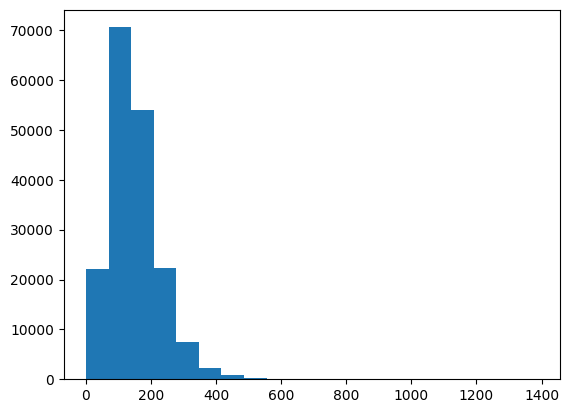

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 20)

In [ ]:
# lets see what character lenght covers 95% of our data
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

Let's now set the max_tokens for our character level tokenizer

In [ ]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char level tokenizer
num_char_tokens = len(alphabet)+ 2 # 2 is for spaces and OOV token(['UKN'])
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length = output_seq_char_len,
                                    standardize= 'lower_and_strip_punctuation',
                                    name = 'char_vectorizer'
                                    )
char_vectorizer.adapt(train_chars)


In [ ]:
# check character vocabulary
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in the vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least commong characters: {char_vocab[-5:]}')


Number of different characters in the vocab: 28
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least commong characters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [ ]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text :\n{random_train_chars}')
print(f'\nlen of chars:\n{len(random_train_chars)}')
vectorized_chars = char_vectorizer(random_train_chars)
print(f'\nVectorized chars: \n{vectorized_chars}')
print(f'\nLen of vectorized chars: \n{len(vectorized_chars)}')
print(f'Shape of embeddings:{vectorized_chars.shape}')

Charified text :
e f f e c t i v e   i n t e r v e n t i o n s   t o   i m p r o v e   m e d i c a t i o n   a d h e r e n c e   a r e   u s u a l l y   c o m p l e x   a n d   e x p e n s i v e   .

len of chars:
181

Vectorized chars: 
[ 2 17 17  2 11  3  4 21  2  4  6  3  2  8 21  2  6  3  4  7  6  9  3  7
  4 15 14  8  7 21  2 15  2 10  4 11  5  3  4  7  6  5 10 13  2  8  2  6
 11  2  5  8  2 16  9 16  5 12 12 19 11  7 15 14 12  2 24  5  6 10  2 24
 14  2  6  9  4 21  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  

In [ ]:
# create char embedding layer
char_embed = layers.Embedding(input_dim = num_char_tokens, #number of differect characters
                              output_dim = 25, #embedding dimension of each character
                              mask_zero = False,
                              name = 'char_embed'
                              )

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a m o n g   @   p a t i e n t s   w i t h   p c i   o f   n a t i v e   c o r o n a r y   l e s i o n s   o n l y   ,   t h e r e   w a s   o n l y   a   n o n - s i g n i f i c a n t   d i f f e r e n c e   i n   t v r   b e t w e e n   p a t i e n t s   w i t h   p r e v i o u s   c a b g   v e r s u s   p a t i e n t s   w i t h o u t   p r e v i o u s   c a b g   (   @   %   v s .   @   %   ,   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-0.04287471  0.01259576 -0.02649095 ... -0.04359357 -0.02968253
    0.04677354]
  [ 0.00955681 -0.01806764 -0.03844818 ... -0.03872734 -0.01767546
   -0.01368854]
  [ 0.00121     0.03598864 -0.04633382 ... -0.03827207  0.02123671
    0.01546332]
  ...
  [-0.01212382  0.01794289 -0.03818683 ... -0.03745557 -0.00492612
    0.01376386]
  [-0.01212382  0.01794289 -0.03818683 ... -0.03745557 -0.00492612
    0.01376386]
  [-0.01212382  0.01794289 -0.03818683 ... -0.0374555

# Building a Conv1D model to  fit on character embeddings

In [ ]:
inputs = layers.Input(shape = (1,),dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64, activation = 'relu', kernel_size = 5, padding = 'same')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name= 'model_3_Conv1D_char_embedding')

# compile model
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics =['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_Conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# create char dataset with prefetch
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4252 - loss: 1.3874 - val_accuracy: 0.5785 - val_loss: 1.0412
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5873 - loss: 1.0320 - val_accuracy: 0.6257 - val_loss: 0.9400
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6295 - loss: 0.9411 - val_accuracy: 0.6592 - val_loss: 0.8720


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


array([[0.20782064, 0.29869598, 0.1865075 , 0.26794323, 0.03903271],
       [0.18066926, 0.6909145 , 0.00376759, 0.08926184, 0.03538682],
       [0.07728146, 0.12660426, 0.39308506, 0.32758087, 0.07544827],
       ...,
       [0.03283415, 0.0650356 , 0.17990275, 0.05210508, 0.6701225 ],
       [0.08647835, 0.15170626, 0.31940773, 0.07197806, 0.37042966],
       [0.30750096, 0.61304504, 0.03415972, 0.04128096, 0.00401336]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 65.71229974844432,
 'precision': 0.6547454557379443,
 'recall': 0.6571229974844432,
 'f1': 0.6467989297136318}

#Model 4:Combining token embeddings +
#character embeddings(hybrid embedding layer)

In [ ]:
# setup token inputs/model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
# Add a pooling layer to reduce sequence length
token_dense  = layers.Dense(128, activation = 'relu')(token_embeddings)
token_pooled_output = layers.GlobalAveragePooling1D()(token_dense)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_pooled_output)

#setup char inputs/model
char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_output_bi_lstm = layers.Bidirectional(layers.LSTM(25, return_sequences = True))(char_embeddings)
# Add a pooling layer to reduce sequence length
char_pooled_output = layers.GlobalAveragePooling1D()(char_output_bi_lstm)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_pooled_output)

# concatenate token and char inputs(create hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# create output layers - addition of dropout as discussed in paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# construct model
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 55)        │          0 │ token_input[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 55, 128)   │  8,299,648 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 55, 128)   │     16,512 │ token_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 55)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 290, 50)   │     10,200 │ char_embed[3][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dense_3[0][0],    │
│ (GlobalAveragePool… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 50)        │          0 │ bidirectional_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 178)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 200)       │     35,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │      1,005 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,364,915 (31.91 MB)

 Trainable params: 8,364,915 (31.91 MB)

 Non-trainable params: 0 (0.00 B)

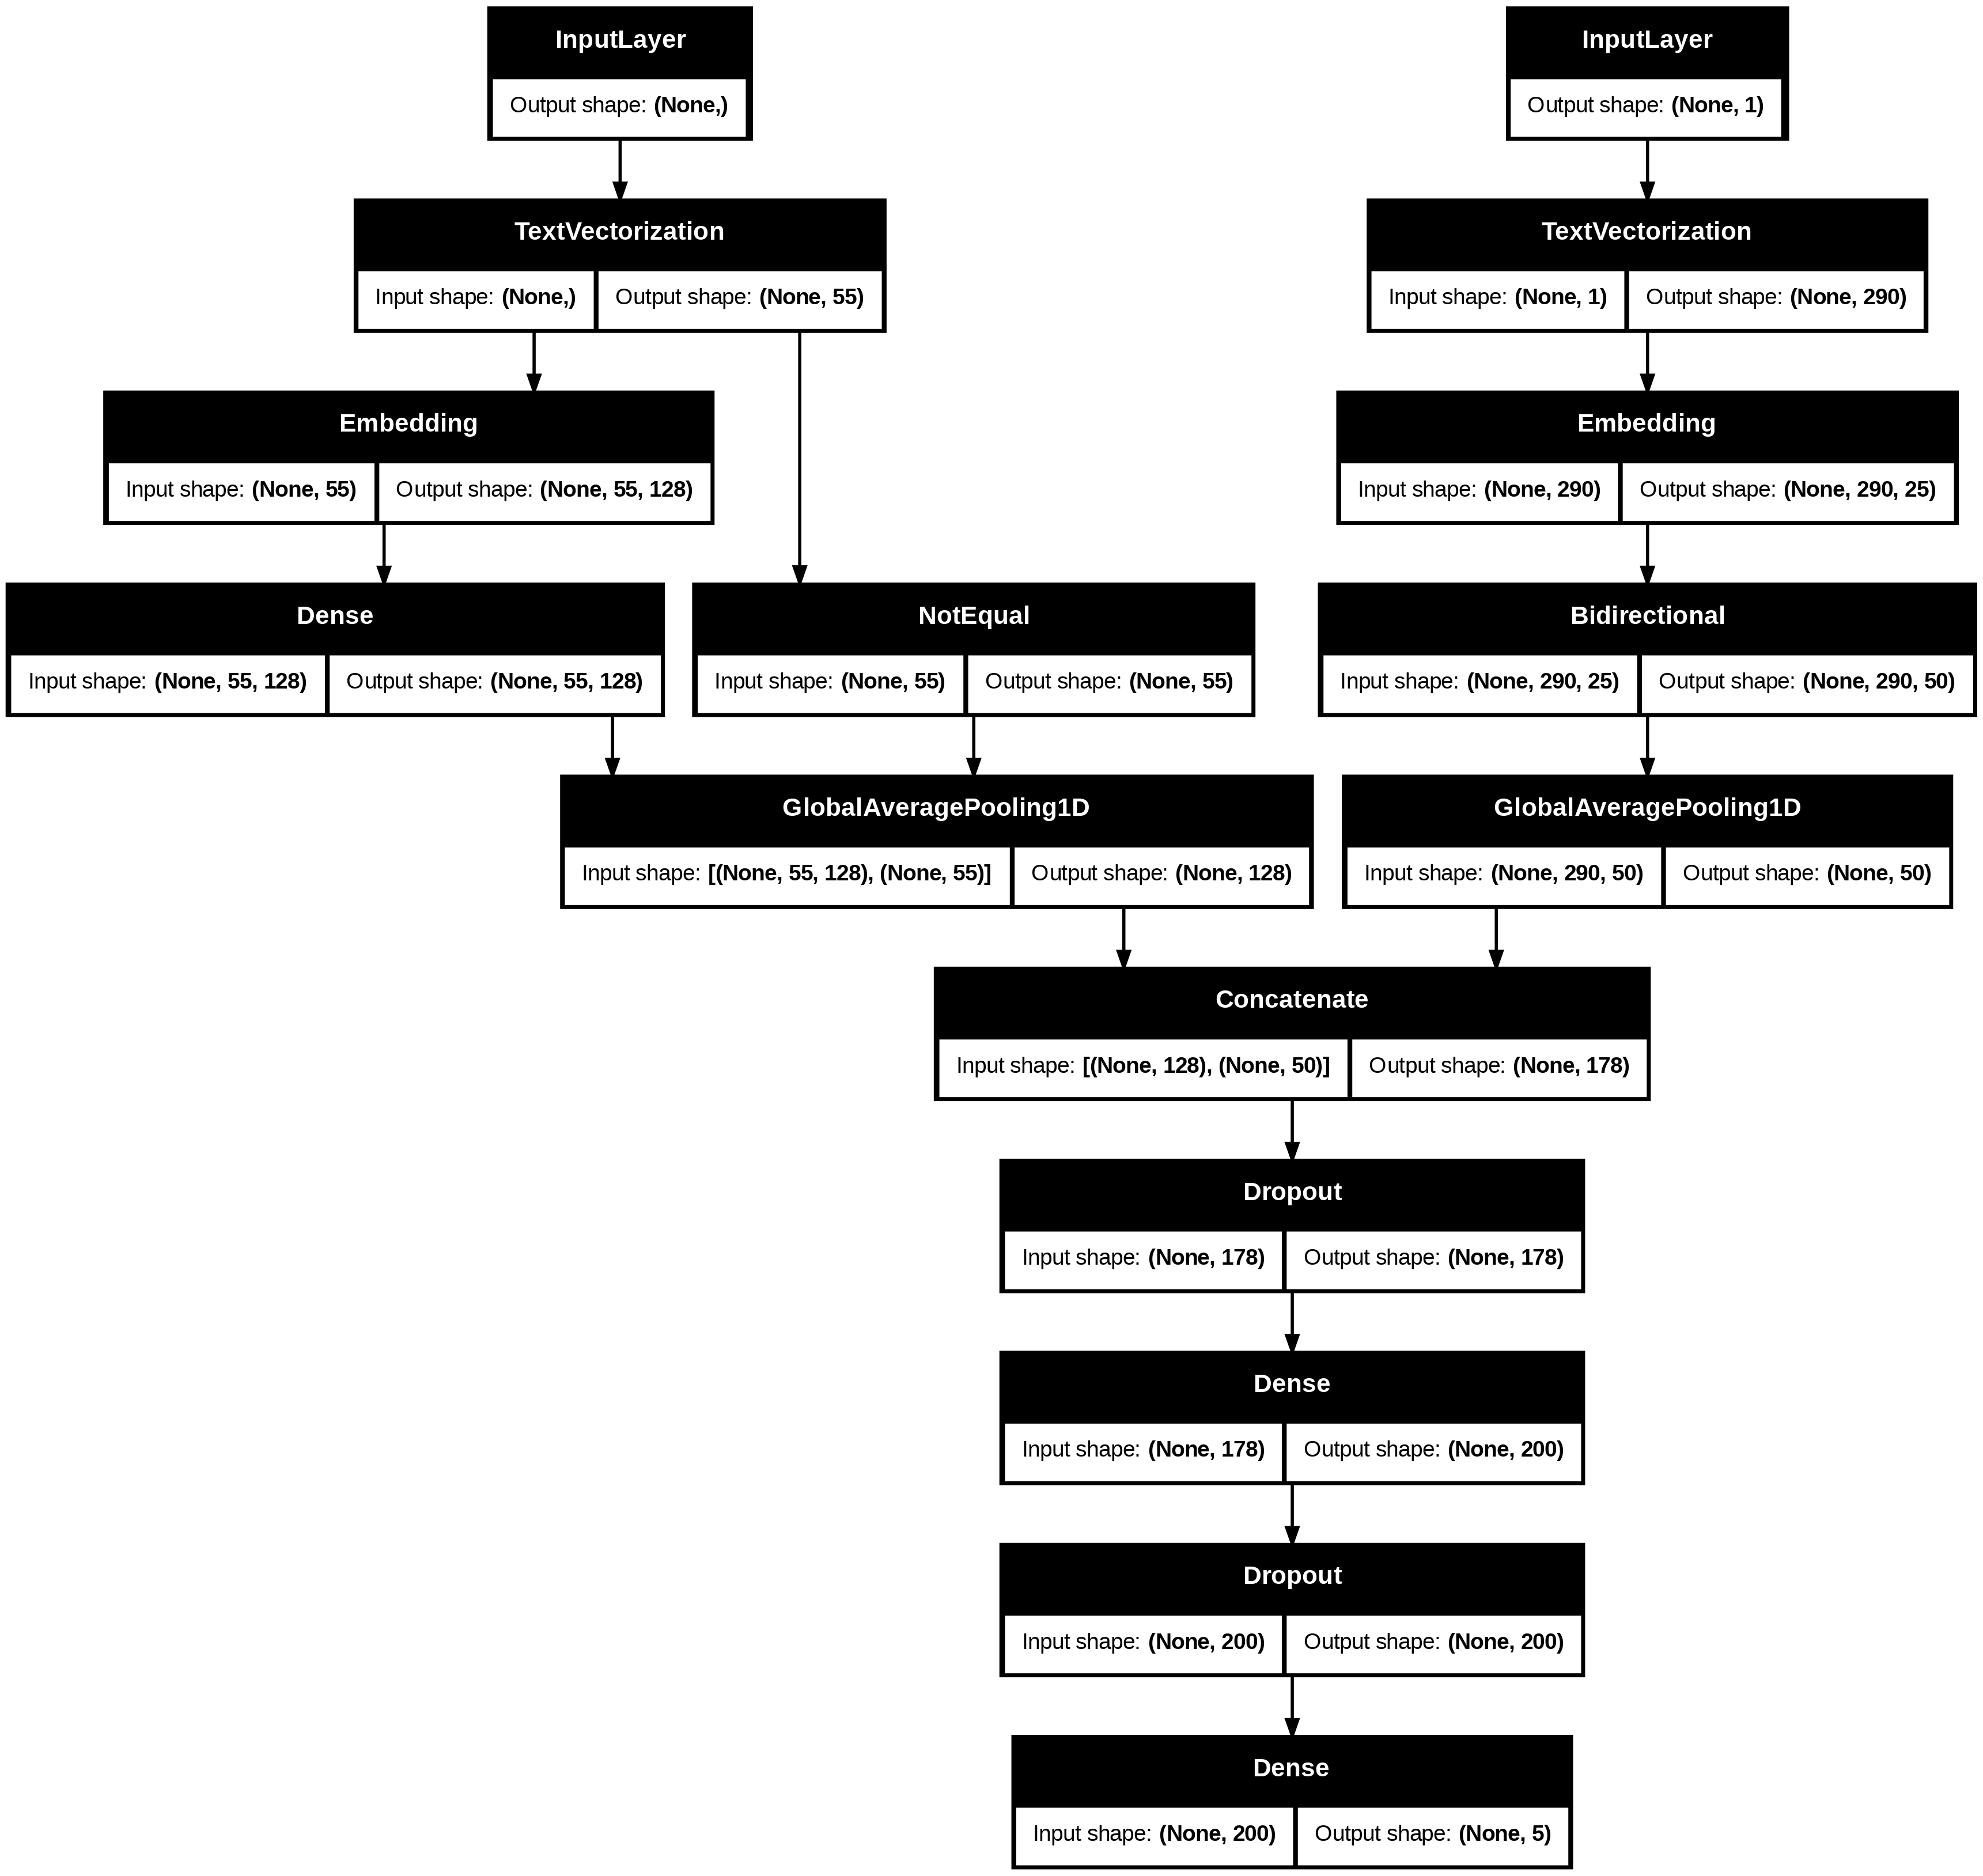

In [ ]:
# plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes = True,rankdir = 'TB')

In [ ]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

## Combining token and character data into a tf.data Dataset

In [ ]:
# combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combine data and labels

# prefetch and batch train_data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same for validation data
# combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels

# prefetch and batch val_data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_char_token_dataset ,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##fitting the model

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset, #train on dataset of token and characters
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.1240 - loss: nan - val_accuracy: 0.1157 - val_loss: nan
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.1285 - loss: nan - val_accuracy: 0.1157 - val_loss: nan
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1225 - loss: nan - val_accuracy: 0.1157 - val_loss: nan


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.1154 - loss: nan


[nan, 0.11415993422269821]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step


array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Model 5: Token embeddings+character embeddings +positional embeddings

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called feature engineering.

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


##Create positional embedding

In [ ]:
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

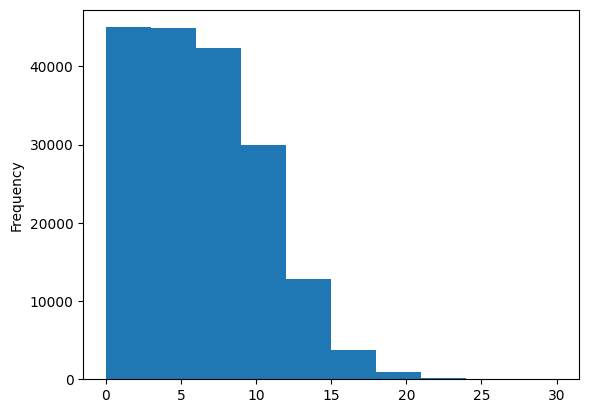

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# use tensorflow to create one hot encoded tensors fo our line numbers
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)


In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [ ]:
train_df['total_lines'].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

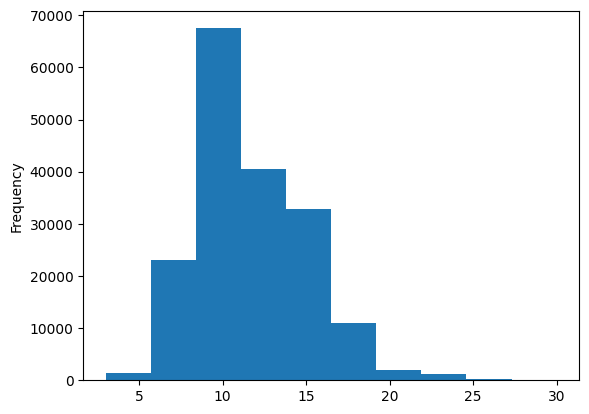

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

In [ ]:
# lets one hot encode ourt total lines
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 15)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 15)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Build a Tribrid embedding model

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we're going to go through the following steps:

* Create a token-level model (similar to model_1)
* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
* Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
* Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
* Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
* Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
* Create an output layer to accept the tribrid embedding and output predicted label probabilities
* Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# token inputs
token_inputs = layers.Input(shape =[],dtype = 'string', name = 'token_inputs')
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_outputs  = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs =token_outputs )

# char inputs
char_inputs = layers.Input(shape = (1,), dtype = 'string', name  = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm  = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# line number inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32, name = 'line_number_input')
x = layers.Dense(32,activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# total lines input
total_lines_inputs = layers.Input(shape = (15,), dtype = tf.int32, name = 'total_lines_input')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                   x)

# combine token and char embeddings
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output,
                                                                                char_model.output])
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combine positional embeddings with combined token and char embeddings into  a tribrid model
z = layers.Concatenate(name = 'token_char_positional_embedding')([line_number_model.output,
                                                                  total_lines_model.output,
                                                                  z])

# create output layer
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(z)

# put together model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 55, 128), (None, 64)]

In [ ]:
model_5.summary()

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True, rankdir = 'TB')

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_pos_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_pos_token_dataset,
                              validation_steps = int(0.1*len(val_pos_char_token_dataset)))

In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose = 1)
model_5_pred_probs

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

In [ ]:
model_5_results = calculate_results(y_true = labels_encoded,
                                    y_pred = model_5_preds
                                    )
model_5_results

#compare model results

In [ ]:
all_model_results = pd.Dataframe({'baseline':baseline_results,
                                  'custom_token_embed_conv1d':model_1_results,
                                  # 'pretrained_token_embed':model_2_results,
                                  'custom_char_embed_conv1d':model_3_results,
                                  'hybrid_char_token_embed':model_4_results,
                                  'tribrid_pos_char_token_embed':model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy']/100


In [ ]:
all_model_results.plot(kind ='bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0))

In [ ]:
all_model_results.sort_values('f1',ascending = False)['f1'].plot(kind = 'bar', figsize = (10,7))

# Save and load best model

In [ ]:
model_5.save('skimlit_tribrid_model.h5')

In [ ]:

# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skimlit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

In [ ]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

In [ ]:
laoded_model.summary()